In [1]:
pip install -r requirements.txt

  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl.metadata (2.3 kB)
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.8 MB 8.4 MB/s eta 0:00:02
   ----- ---------------------------------- 1.8/12.8 MB 4.6 MB/s eta 0:00:03
   ------ --------------------------------- 2.1/12.8 MB 5.1 MB/s eta 0:00:03
   --------- ------------------------------ 3.1/12.8 MB 4.4 MB/s eta 0:00:03
   --------- ------------------------------ 3.1/12.8 MB 4.4 MB/s eta 0:00:03
   ---------- ----------------------------- 3.4/12.8 MB 2.7 MB/s eta 0:00:04
   ------------- -------------------------- 4.2/12.8 MB 3.1 MB/s eta 0:00:03
   ------------- -------------------------- 4.2/12.8 MB 3.1 MB/s eta 0:00:03
   ---------------- -----------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.2 requires torch==2.0.1, but you have torch 2.2.1 which is incompatible.


In [3]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tabulate import tabulate


In [3]:
annotations = pd.read_csv('_annotations.csv')

In [6]:
image_files = os.listdir('train')
total_images = len(image_files)
print(f"Total number of images: {total_images}")


Total number of images: 3239


In [7]:
unique_defects = annotations['class'].unique()
print("Unique defects:")
print(unique_defects)

Unique defects:
['spot' 'acne' 'pimple' 'scar']


0 - Acne : bumpy, small-big, white-brown cysts with no-redness, NOT RED.

1 - Pimple : bumpy, small-big, red-white cysts, any red big bump, MUST BE RED.

2 - Spots : flat, small, circular, dark brown.

3 - Mole1 : flat/black/small/concentrated (til type Moles)

4 - Mole2 : bumpy/black/dark-brown (Mussa type Moles)

5 - Scar : FLAT/ ANY SHAPE/ ANY SHADE

Since we don't need moles ( since it doesn't come under skin defects ), removing the mole class

In [4]:
annotations = annotations[~annotations['class'].isin(['mole1', 'mole2'])]

In [8]:
image_names_with_defects = annotations['filename'].unique()
undefective_images = set(image_files) - set(image_names_with_defects)
print(f"Number of undefective images: {len(undefective_images)}")

Number of undefective images: 436


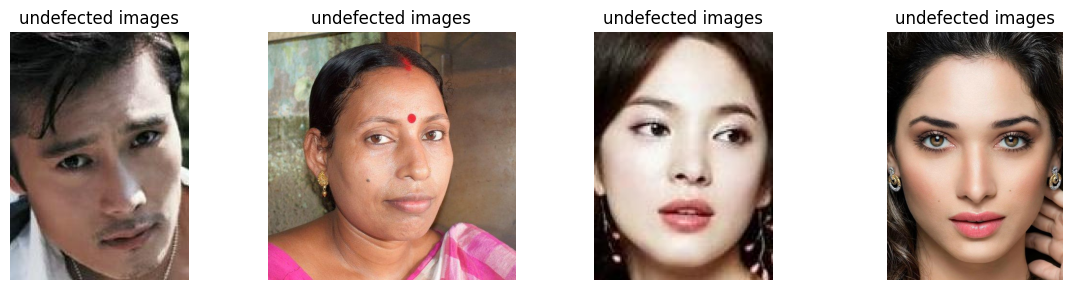

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for j, i in enumerate(undefective_images):
    if j == 4:
        break
    img_path = os.path.join('train', i)
    img = mpimg.imread(img_path)
    ax = axes[j]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("undefected images")

plt.tight_layout()
plt.show()

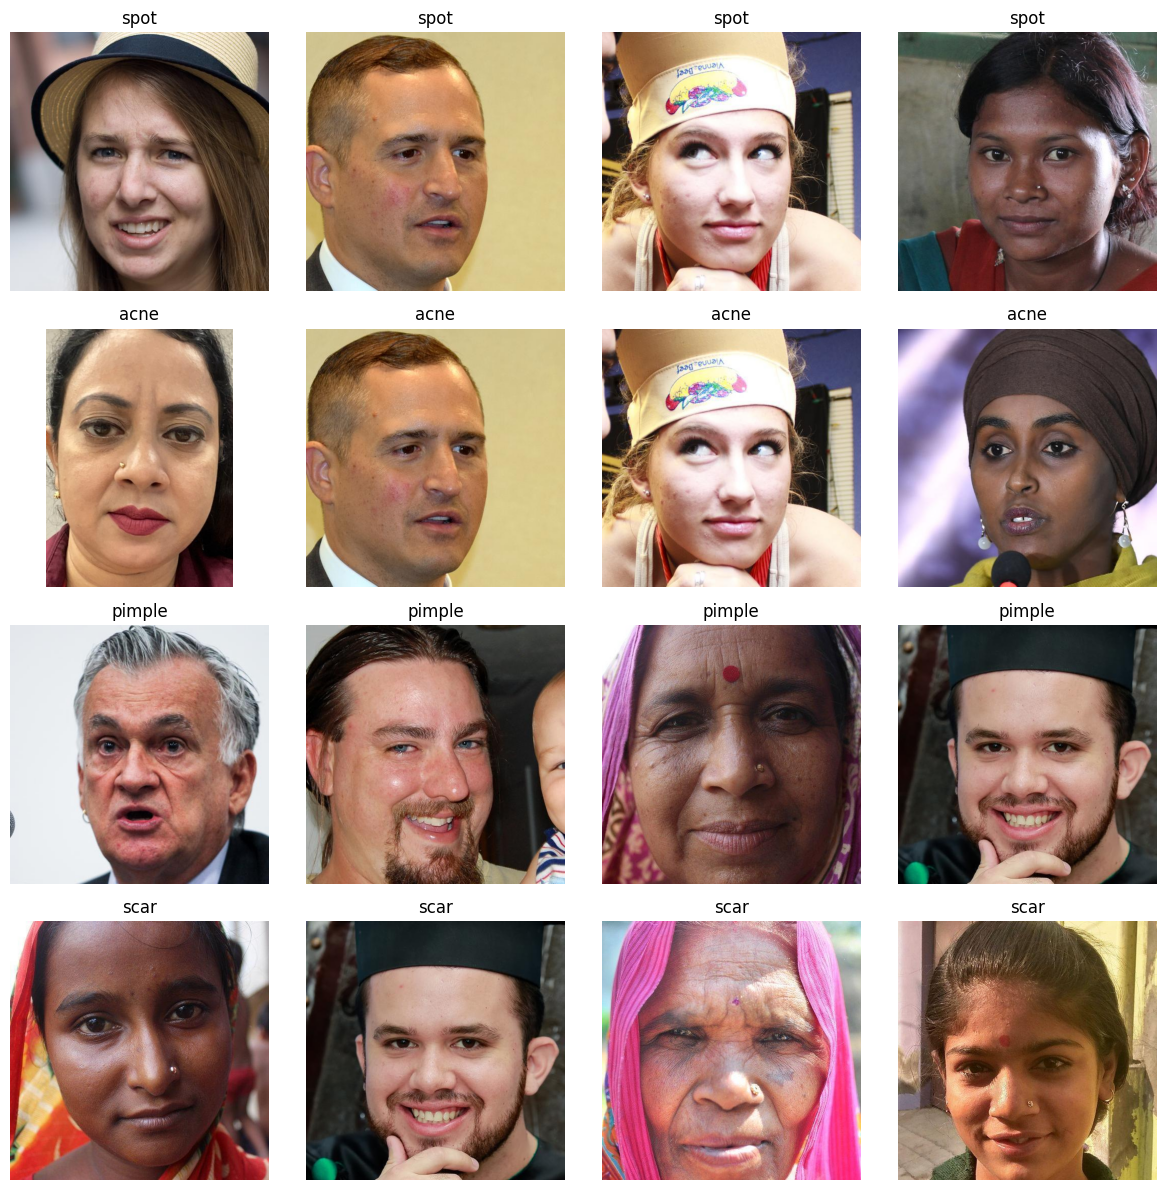

In [10]:
defect_classes = annotations['class'].unique()
fig, axes = plt.subplots(len(defect_classes), 4, figsize=(12, len(defect_classes) * 3))
for i, defect in enumerate(defect_classes):
    defect_images = annotations[annotations['class'] == defect]['filename'].unique()[:4]
    for j, img_file in enumerate(defect_images):
        img_path = os.path.join('train', img_file)
        img = mpimg.imread(img_path)
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{defect}")

plt.tight_layout()
plt.show()

In [9]:
for defect in defect_classes:
    defect_images = annotations[annotations['class'] == defect]['filename'].unique()
    defect_percentage = (len(defect_images) / total_images) * 100
    print(f"Number of images with at least one {defect}: {len(defect_images)} ({defect_percentage:.2f}%)")
undefect_percentage = (len(undefective_images) / total_images) * 100
print(f"Number of images with no defects: {len(undefective_images)} ({undefect_percentage:.2f}%)")

Number of images with at least one spot: 2063 (63.69%)
Number of images with at least one acne: 2038 (62.92%)
Number of images with at least one pimple: 507 (15.65%)
Number of images with at least one scar: 471 (14.54%)
Number of images with no defects: 436 (13.46%)


Binary classification

In [13]:
binary_data = annotations.copy()

In [12]:
binary_df = pd.DataFrame({'filename': list(image_files)})
binary_df['isHealthy'] = binary_df['filename'].apply(lambda x: 0 if x in image_names_with_defects else 1)

In [13]:
IMAGE_SIZE = (224, 224)
def load_and_preprocess_image(file_path):
    img = cv2.imread(file_path)
    if img is None:
        return None
    img = cv2.resize(img, IMAGE_SIZE)
    img = img / 255.0
    return img

def prepare_data(dataset_path, annotations):
    images = []
    labels = []

    for _, row in annotations.iterrows():
        file_path = os.path.join(dataset_path, row['filename'])
        img = load_and_preprocess_image(file_path)
        
        if img is not None:
            images.append(img)
            labels.append(row['isHealthy'])

    return np.array(images), np.array(labels)

In [14]:
images, labels = prepare_data('train', binary_df)

In [ ]:
IMAGE_SIZE = (224, 224)
LBP_RADIUS = 3
LBP_POINTS = 8 * LBP_RADIUS
AUGMENTATION_LIMIT = 5000
SEED = 42

In [22]:
def split_data(images, labels, test_size=0.2, val_size=0.2):
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=test_size + val_size, random_state=SEED, stratify=labels)
    val_size_adjusted = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size_adjusted, random_state=SEED, stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val, y_test

def extract_hog_features(images):
    features = []
    for img in images:
        feature, _ = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=-1)
        features.append(feature)
    return np.array(features)


def extract_lbp_features(images):
    features = []
    for img in images:
        img = np.uint8(img)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray_img, LBP_POINTS, LBP_RADIUS, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), range=(0, LBP_POINTS + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # Normalize
        features.append(hist)
    return np.array(features)


def train_model(features, labels, model_name="HOG"):
    clf = RandomForestClassifier(random_state=SEED)
    clf.fit(features, labels)
    return clf

def evaluate_model(model, features, labels):
    predictions = model.predict(features)
    accuracy = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions, output_dict=True)
    return accuracy, report


def augment_data(images, labels):
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=15,
        brightness_range=[0.8, 1.2],
        width_shift_range=0.1,
        height_shift_range=0.1
    )
    augmented_images, augmented_labels = [], []
    for img, label in zip(images, labels):
        augmented_images.append(img)
        augmented_labels.append(label)
        for _ in range(3): 
            augmented = datagen.random_transform(img)
            augmented_images.append(augmented)
            augmented_labels.append(label)
            if len(augmented_images) >= AUGMENTATION_LIMIT:
                return np.array(augmented_images), np.array(augmented_labels)
    return np.array(augmented_images), np.array(augmented_labels)


def build_cnn(input_shape, num_classes=1):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy' if num_classes == 1 else 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def train_cnn_model(X_train, y_train, X_val, y_val, input_shape, num_classes=1):
    model = build_cnn(input_shape, num_classes)
    model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)
    return model



In [23]:
images.shape

(3239, 224, 224, 3)

In [24]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=SEED)


In [28]:
hog_features_train = extract_hog_features(X_train)
hog_features_test = extract_hog_features(X_temp)
hog_clf = train_model(hog_features_train, y_train, model_name="HOG")
hog_accuracy, hog_report = evaluate_model(hog_clf, hog_features_test, y_temp)

In [29]:
hog_report

{'0': {'precision': 0.9056,
  'recall': 0.9929824561403509,
  'f1-score': 0.9472803347280334,
  'support': 570.0},
 '1': {'precision': 0.8260869565217391,
  'recall': 0.24358974358974358,
  'f1-score': 0.37623762376237624,
  'support': 78.0},
 'accuracy': 0.9027777777777778,
 'macro avg': {'precision': 0.8658434782608695,
  'recall': 0.6182860998650472,
  'f1-score': 0.6617589792452048,
  'support': 648.0},
 'weighted avg': {'precision': 0.8960289855072463,
  'recall': 0.9027777777777778,
  'f1-score': 0.878543712111797,
  'support': 648.0}}

In [30]:
hog_accuracy

0.9027777777777778

In [31]:
import joblib
model_filename = 'hog_random_forest_model.joblib'
joblib.dump(hog_clf, model_filename)

print(f"Model saved to {model_filename}")

Model saved to hog_random_forest_model.joblib


In [25]:
lbp_features_train = extract_lbp_features(X_train)
lbp_features_test = extract_lbp_features(X_temp)
lbp_clf = train_model(lbp_features_train, y_train, model_name="LBP")
lbp_accuracy, lbp_report = evaluate_model(lbp_clf, lbp_features_test, y_temp)

c:\Users\lashicr7\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lashicr7\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lashicr7\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [26]:
lbp_report

{'0': {'precision': 0.8796296296296297,
  'recall': 1.0,
  'f1-score': 0.9359605911330049,
  'support': 570.0},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 78.0},
 'accuracy': 0.8796296296296297,
 'macro avg': {'precision': 0.4398148148148148,
  'recall': 0.5,
  'f1-score': 0.46798029556650245,
  'support': 648.0},
 'weighted avg': {'precision': 0.7737482853223594,
  'recall': 0.8796296296296297,
  'f1-score': 0.8232986681262544,
  'support': 648.0}}

In [27]:
lbp_accuracy

0.8796296296296297

In [29]:
import joblib
model_filename = 'lbp_random_forest_model.joblib'
joblib.dump(lbp_clf, model_filename)

print(f"Model saved to {model_filename}")

Model saved to lbp_random_forest_model.joblib


In [32]:
X_train_aug, y_train_aug = augment_data(X_train, y_train)

MemoryError: Unable to allocate 5.61 GiB for an array with shape (5000, 224, 224, 3) and data type float64

Tried to augment the data but got out of memory error due to no validation class

In [ ]:
# hog_features_train = extract_hog_features(X_train_aug)
# hog_features_test = extract_hog_features(X_temp)
# hog_clf = train_model(hog_features_train, y_train_aug, model_name="HOG")
# hog_accuracy, hog_report = evaluate_model(hog_clf, hog_features_test, y_temp)

In [23]:
X_train = []
X_test = []
X_train_aug = []
y_train_aug = []

In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(images, labels)
X_train_aug, y_train_aug = augment_data(X_train, y_train)

In [18]:
cnn_input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
X_train_aug = X_train_aug.reshape((-1, *cnn_input_shape))
X_val = X_val.reshape((-1, *cnn_input_shape))
X_test = X_test.reshape((-1, *cnn_input_shape))
cnn_model = train_cnn_model(X_train_aug, y_train_aug, X_val, y_val, cnn_input_shape)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)

Epoch 1/10
157/157 [==============================] - 347s 2s/step - loss: 0.4362 - accuracy: 0.8638 - val_loss: 0.3510 - val_accuracy: 0.8657
Epoch 2/10
157/157 [==============================] - 305s 2s/step - loss: 0.3999 - accuracy: 0.8660 - val_loss: 0.3431 - val_accuracy: 0.8657
Epoch 3/10
157/157 [==============================] - 357s 2s/step - loss: 0.3912 - accuracy: 0.8702 - val_loss: 0.3043 - val_accuracy: 0.8889
Epoch 4/10
157/157 [==============================] - 333s 2s/step - loss: 0.3781 - accuracy: 0.8744 - val_loss: 0.3104 - val_accuracy: 0.8719
Epoch 5/10
157/157 [==============================] - 348s 2s/step - loss: 0.3559 - accuracy: 0.8756 - val_loss: 0.3088 - val_accuracy: 0.9074
Epoch 6/10
157/157 [==============================] - 348s 2s/step - loss: 0.3394 - accuracy: 0.8806 - val_loss: 0.2689 - val_accuracy: 0.9151
Epoch 7/10
157/157 [==============================] - 332s 2s/step - loss: 0.3185 - accuracy: 0.8876 - val_loss: 0.2538 - val_accuracy: 0.8981

In [19]:
model_save_path = 'trained_cnn_model.h5'
cnn_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to trained_cnn_model.h5


In [20]:
loaded_model = tf.keras.models.load_model('trained_cnn_model.h5')
loaded_model.evaluate(X_test, y_test, verbose=1)

21/21 [==============================] - 10s 405ms/step - loss: 0.4756 - accuracy: 0.8904


[0.4756385087966919, 0.8904321193695068]

In [32]:
results = [
["HOG + Random Forest (original)", hog_accuracy],
["LBP + Random Forest (original)", lbp_accuracy],
["CNN + Augmentation (augmented)", cnn_accuracy]
]
print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="grid"))


+--------------------------------+------------+
| Model                          |   Accuracy |
+================================+============+
| HOG + Random Forest (original) |   0.902778 |
+--------------------------------+------------+
| LBP + Random Forest (original) |   0.87963  |
+--------------------------------+------------+
| CNN + Augmentation (augmented) |   0.890432 |
+--------------------------------+------------+


In [33]:
IMAGE_SIZE = (224, 224)
def load_and_preprocess_image(file_path):
    img = cv2.imread(file_path)
    if img is None:
        return None
    img = cv2.resize(img, IMAGE_SIZE)
    img = img / 255.0
    return img

def prepare_data(dataset_path, annotations):
    images = []
    labels = []

    for _, row in annotations.iterrows():
        file_path = os.path.join(dataset_path, row['filename'])
        img = load_and_preprocess_image(file_path)
        
        if img is not None:
            images.append(img)
            labels.append(row['class'])

    return np.array(images), np.array(labels)


def encode_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
    encoded_labels = np.array([label_mapping[label] for label in labels])
    return encoded_labels, label_mapping

images, labels = prepare_data('train', annotations)
labels, label_mapping = encode_labels(labels)

MemoryError: Unable to allocate 1.15 MiB for an array with shape (224, 224, 3) and data type float64

Tried to prepare data for multi label classification but got out of memory error